In [2]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    GridSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [4]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [5]:
X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
for df in [X_train, X_test]:
    df = clean_column_names(df)
y_train = train["churn"].astype(int)
treatment_train = train["outreach"].astype(int)

y_test = test["churn"].astype(int)
treatment_test = test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

Aggregating train features...
Aggregating test features...
Training data: 10000 samples; test data: 10000 samples

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


Qini AUC (area over random): -265167.8122
Normalized Qini AUC: -13.1171


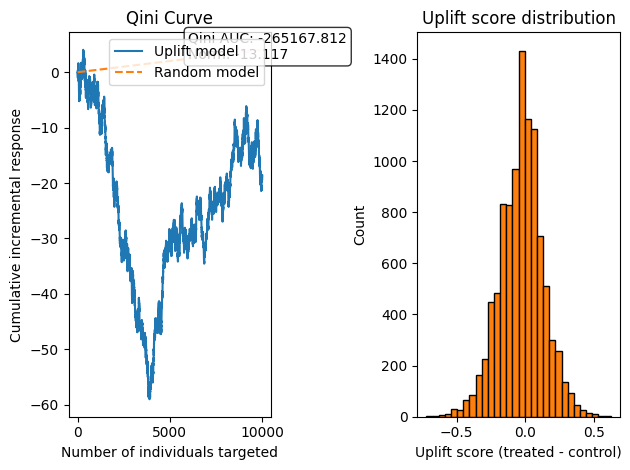

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------------------------
#  dataset
# ---------------------------
X = X_train
treatment = treatment_train
y = y_train
# ---------------------------
# 1. Propensity score estimation
# ---------------------------
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(X, treatment)
propensity_scores = prop_model.predict_proba(X)[:, 1]

# ---------------------------
# 2. Train separate outcome models (T-learner)
# ---------------------------
weights_treated = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

model_treated = RandomForestClassifier(n_estimators=100, random_state=42)
model_treated.fit(
    X[treatment == 1], y[treatment == 1], sample_weight=weights_treated[treatment == 1]
)

model_control = RandomForestClassifier(n_estimators=100, random_state=42)
model_control.fit(
    X[treatment == 0], y[treatment == 0], sample_weight=weights_control[treatment == 0]
)

# ---------------------------
# 3. Predict outcomes under treatment and control
# ---------------------------
y_pred_treated = model_treated.predict_proba(X_test)[:, 1]
y_pred_control = model_control.predict_proba(X_test)[:, 1]

uplift_scores = y_pred_treated - y_pred_control


# ---------------------------
# 4. Qini curve
# ---------------------------
def qini_curve(y, treatment, uplift):
    """Compute Qini curve points"""
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift})
    df = df.sort_values("uplift", ascending=False)

    cum_treated = df["t"].cumsum()
    cum_control = (~df["t"].astype(bool)).cumsum()

    cum_outcome_treated = (df["y"] * df["t"]).cumsum()
    cum_outcome_control = (df["y"] * (1 - df["t"])).cumsum()

    # Qini: difference in cumulative outcomes scaled by group sizes
    qini = cum_outcome_treated - cum_outcome_control * (
        cum_treated / np.maximum(cum_control, 1)
    )
    return qini


qini = qini_curve(y_test, treatment_test, uplift_scores)


# Qini curve subplot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(qini) + 1), qini, label="Uplift model")
plt.plot([0, len(qini)], [0, qini.max()], "--", label="Random model")
plt.xlabel("Number of individuals targeted")
plt.ylabel("Cumulative incremental response")
plt.title("Qini Curve")
plt.legend()

# compute Qini AUC (area between model qini curve and random model)
x = np.arange(1, len(qini) + 1)
qini_vals = qini.values

model_auc = np.trapz(qini_vals, x)
random_line = np.linspace(0, qini_vals.max(), len(qini_vals))
random_auc = np.trapz(random_line, x)

qini_auc = model_auc - random_auc
qini_auc_norm = qini_auc / random_auc if random_auc != 0 else np.nan

print(f"Qini AUC (area over random): {qini_auc:.4f}")
print(f"Normalized Qini AUC: {qini_auc_norm:.4f}")

# annotate qini plot
plt.subplot(1, 2, 1)
plt.annotate(
    f"Qini AUC: {qini_auc:.3f}\nNorm: {qini_auc_norm:.3f}",
    xy=(0.6 * len(qini_vals), 0.6 * qini_vals.max()),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
)

# second subplot: uplift score distribution for diagnostics
plt.subplot(1, 2, 2)
plt.hist(uplift_scores, bins=30, color="C1", edgecolor="k")
plt.xlabel("Uplift score (treated - control)")
plt.ylabel("Count")
plt.title("Uplift score distribution")
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Qini curve')

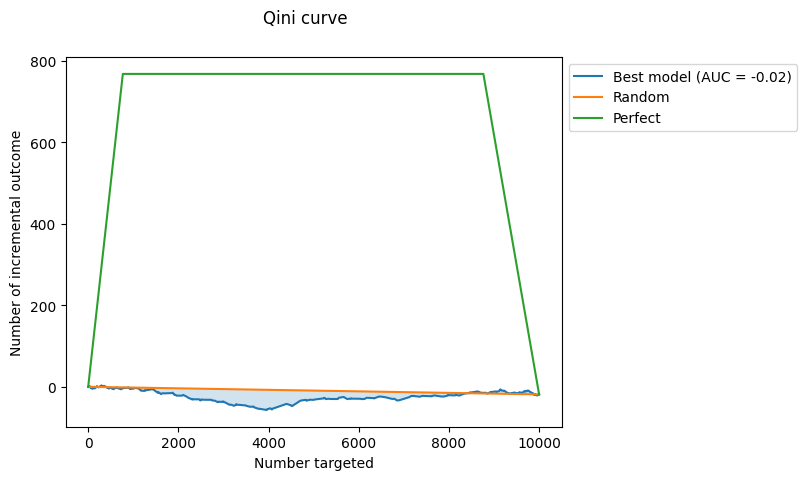

In [13]:
bets_disp = plot_qini_curve(
    y_test, uplift_scores, treatment_test, perfect=True, name="Best model"
)
bets_disp.figure_.suptitle("Qini curve")
# y_test, treatment_test, uplift_scores